In [1]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.toolbox.eval import _tiou
# from src.toolbox.data_converters import Charade2Instances, ActivityNetCap2Instances
import pickle as pkl
import json
import os
import random
from scipy.spatial.distance import pdist, squareform
from scipy.special import softmax

pair_iou = lambda u, v: _tiou(u[None, :], v)

In [36]:
def compute_avr_iou(locations):
    ious = squareform(pdist(locations, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    return ious.mean(axis=-1)

def get_representative(locations):
    ious = squareform(pdist(locations, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    return locations[np.argmax(ious.mean(axis=-1))]

def representative_metric(results, multiref_ground_truth):
    is_positive = []
    for query, locations, _, _ in results:
        for gt_instance in multiref_ground_truth:
            if query == gt_instance[0]:
                rep_loc = get_representative(gt_instance[1])
                iou = _tiou(np.asarray([locations[0][:2]]), rep_loc)
                is_positive.append(max(iou) > .5)
                break
    return is_positive

def nearest_neighbor_metric(results, multiref_ground_truth, weight_on=False):
    is_positive = []
    confidence = []
    for query, locations, _, _ in results:
        for gt_instance in multiref_ground_truth:
            if query == gt_instance[0]:
                ious = _tiou(gt_instance[1][:,:2], locations[0][:2])
                is_positive.append(max(ious) > .5)
                if weight_on:
                    weights = compute_avr_iou(gt_instance[1][:,:2])
                    confidence.append(weights[np.argmax(ious)]) 
                break
    return is_positive, confidence if weight_on else is_positive

def representative_metric(results, multiref_ground_truth, weight_on=False):
    is_positive = []
    for query, locations, _, _ in results:
        for gt_instance in multiref_ground_truth:
            if query == gt_instance[0]:
                rep = get_representative(gt_instance[1][:,:2])
                iou = _tiou(np.asarray([rep]), locations[0][:2])
                is_positive.append(iou > .5)
                break
    return is_positive


def second_nearest_neighbor_metric(results, multiref_ground_truth, weight_on=False):
    is_positive = []
    confidence = []
    for query, locations, _, _ in results:
        for gt_instance in multiref_ground_truth:
            if query == gt_instance[0]:
                ious = _tiou(gt_instance[1][:,:2], locations[0][:2])
                idx_2nd_best = np.argsort(ious)[-2]
                is_positive.append(ious[idx_2nd_best] > .5)
                if weight_on:
                    weights = compute_avr_iou(gt_instance[1][:,:2])
                    confidence.append(weights[idx_2nd_best]) 
                break
    return is_positive, confidence if weight_on else is_positive

def get_representative(locations):
    ious = squareform(pdist(locations, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    return locations[np.argmax(ious.mean(axis=-1))]

def compute_iou_with_random_human_and_representantive(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T
    
    if np.all(pred[:,0]==pred[0,0]) and np.all(pred[:,1]==pred[0,1]):
        return 1
    
    rep = get_representative(pred)
    keep = np.any(np.vstack([(pred[:,0]!=rep[0]), (pred[:,1]!=rep[1])]), axis=0)
    pred = pred[keep]
    if len(pred)==0:
        raise RuntimeError
    pred = random.choice(pred) 
    ious = _tiou(pred[None,:], rep)
    return ious

def compute_iou_with_random_human_and_nn_reference(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T
    
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    ious = ious.max(axis=1)
    return random.choice(ious)

# Evaluation on Charade-STA

66.8 (1.16)
83.4 (0.89)


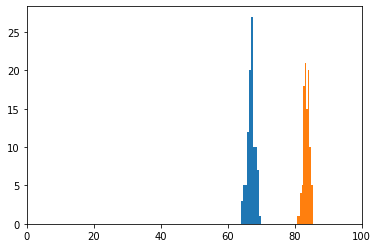

In [26]:
# Randomly sampled human evaluation
def eval_human_performance_charades():
    data = []
    for data_file in os.listdir("data/raw/AMT/charade-sta/"):
        if data_file.split(".")[-1] == 'csv':
            data.append(pd.read_csv(f"data/raw/AMT/charade-sta/{data_file}"))
    data = pd.concat(data)

    for fnc in [compute_iou_with_random_human_and_representantive, compute_iou_with_random_human_and_nn_reference]:
        metrics = []
        for _ in range(100):
            human_ious = data.groupby("HITId").apply(fnc).values
            r_at_1 = np.mean(np.hstack(human_ious) > .5)*100
            metrics.append(r_at_1)

        print(f'{np.mean(metrics):.1f} ({np.std(metrics):.2f})')
        
eval_human_performance_charades()

In [28]:
def get_multiref_groundtruth_charade():
    
    data = []
    for data_file in os.listdir("data/raw/AMT/charade-sta/"):
        if data_file.split(".")[-1] == 'csv':
            data.append(pd.read_csv(f"data/raw/AMT/charade-sta/{data_file}"))
    data = pd.concat(data)

    multiref_ground_truth = []
    for _, rows in data.groupby('HITId'):
        description  = rows['Input.description'].values[0]
        video_id = rows['Input.video_url'].values[0].split('.')[0]
        locations = rows[['Answer.start', 'Answer.end', 'Input.length']].values
        locations[:, :2] *= locations[0, -1]/100
        multiref_ground_truth.append(((video_id, description), locations))
        
    return multiref_ground_truth

In [44]:
multiref_ground_truth = get_multiref_groundtruth_charade()
charade_leaderboard_representativeGT = {}

for metric_fnc in [representative_metric, nearest_neighbor_metric]:
    results = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    charade_leaderboard_representativeGT["2D-TAN"] = np.mean(is_positive)*100

    results = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    charade_leaderboard_representativeGT["SCDM"] = np.mean(is_positive)*100

    results = pkl.load(open("reports/figure_src/results/charade/blind(action).pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    charade_leaderboard_representativeGT["Action-aware Blind"] = np.mean(is_positive)*100

R_mr@1(IoU>0.5) : 24.90
R_mr@1(IoU>0.5) : 34.50
R_mr@1(IoU>0.5) : 18.70
R_mr@1(IoU>0.5) : 51.70
R_mr@1(IoU>0.5) : 59.48
R_mr@1(IoU>0.5) : 36.50


In [8]:
multiref_ground_truth = get_multiref_groundtruth_charade()
charade_leaderboard_mr = {}
charade_leaderboard_wmr = {}

results = pkl.load(open("reports/figure_src/results/charade/2d-tan.pkl", "rb"))
is_positive = nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
charade_leaderboard_mr["2D-TAN"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
charade_leaderboard_wmr["2D-TAN"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

results = pkl.load(open("reports/figure_src/results/charade/scdm.pkl", "rb"))
is_positive = nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
charade_leaderboard_mr["SCDM"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
charade_leaderboard_wmr["SCDM"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

results = pkl.load(open("reports/outputs/performance/charade-sta/representative_human.pkl", "rb"))
is_positive = second_nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
charade_leaderboard_mr["Rep. Human"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
charade_leaderboard_wmr["Rep. Human"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

R_mr@1(IoU>0.5) : 51.70
R_mrw@1(IoU>0.5) : 24.76
R_mr@1(IoU>0.5) : 59.48
R_mrw@1(IoU>0.5) : 30.16
R_mr@1(IoU>0.5) : 98.20
R_mrw@1(IoU>0.5) : 61.21


# Evaluation on ActivityNet

In [27]:
# Randomly sampled human evaluation
def eval_human_performance_activitynet():
    datas = []
    data_root = "data/raw/AMT/activitynet/"
    for file in os.listdir(data_root):
        if file.split(".")[-1] != "csv":
            continue
        print(data_root+file)
        data = pd.read_csv(data_root+file)
        if "Answer.error_report" in data.columns:
            invalid_hits = data[data["Answer.error_report"] == "video disabled"]["HITId"].unique()
            data = data[~data["HITId"].isin(invalid_hits)]
        datas.append(data[['HITId', 'WorkerId', 'Input.video_id', 'Input.start_sec', 'Input.end_sec', 'Input.length', 'Input.description', 'Answer.end', 'Answer.start']])
    data = pd.concat(datas)

    for fnc in [compute_iou_with_random_human_and_representantive, compute_iou_with_random_human_and_nn_reference]:
        metrics = []
        for _ in range(100):
            human_ious = data.groupby("HITId").apply(fnc).values
            r_at_1 = np.mean(np.hstack(human_ious) > .5)*100
            metrics.append(r_at_1)

        print(f'{np.mean(metrics):.1f} ({np.std(metrics):.2f})')
        
eval_human_performance_activitynet()

data/raw/AMT/activitynet/Batch_4007877_batch_results.csv
data/raw/AMT/activitynet/Batch_3997812_batch_results.csv
data/raw/AMT/activitynet/Batch_3996080_batch_results.csv
data/raw/AMT/activitynet/Batch_3996408_batch_results.csv
data/raw/AMT/activitynet/Batch_4001034_batch_results.csv
52.3 (1.00)
72.4 (1.07)


In [40]:
def get_multiref_groundtruth_activitynet():
    datas = []
    data_root = "data/raw/AMT/activitynet/"
    for file in os.listdir(data_root):
        if file.split(".")[-1] != "csv":
            continue
        print(data_root+file)
        data = pd.read_csv(data_root+file)
        if "Answer.error_report" in data.columns:
            invalid_hits = data[data["Answer.error_report"] == "video disabled"]["HITId"].unique()
            data = data[~data["HITId"].isin(invalid_hits)]
        datas.append(data[['HITId', 'WorkerId', 'Input.video_id', 'Input.start_sec', 'Input.end_sec', 'Input.length', 'Input.description', 'Answer.end', 'Answer.start']])
    data = pd.concat(datas)
    print(len(data))

    multiref_ground_truth = []
    for _, rows in data.groupby('HITId'):
        description  = rows['Input.description'].values[0]
        video_id = 'v_' + rows['Input.video_id'].values[0]
        locations = rows[['Answer.start', 'Answer.end', 'Input.length']].values
        locations[:, :2] *= locations[0, -1]/100
        multiref_ground_truth.append(((video_id, description), locations))
    return multiref_ground_truth

In [41]:
multiref_ground_truth = get_multiref_groundtruth_activitynet()
activitynet_leaderboard_representativeGT = {}

results = pkl.load(open("reports/figure_src/results/activitynet/2d-tan.pkl", "rb"))
is_positive = representative_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
activitynet_leaderboard_representativeGT["2D-TAN"] = np.mean(is_positive)*100

results = pkl.load(open("reports/figure_src/results/activitynet/scdm.pkl", "rb"))
is_positive = representative_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
activitynet_leaderboard_representativeGT["SCDM"] = np.mean(is_positive)*100

data/raw/AMT/activitynet/Batch_4007877_batch_results.csv
data/raw/AMT/activitynet/Batch_3997812_batch_results.csv
data/raw/AMT/activitynet/Batch_3996080_batch_results.csv
data/raw/AMT/activitynet/Batch_3996408_batch_results.csv
data/raw/AMT/activitynet/Batch_4001034_batch_results.csv
6440
R_mr@1(IoU>0.5) : 36.55
R_mr@1(IoU>0.5) : 31.17


In [45]:
multiref_ground_truth = get_multiref_groundtruth_activitynet()
leaderboard = {}

for metric_fnc in [representative_metric, nearest_neighbor_metric]:
    results = pkl.load(open("reports/figure_src/results/activitynet/2d-tan.pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    leaderboard["2D-TAN"] = np.mean(is_positive)*100

    results = pkl.load(open("reports/figure_src/results/activitynet/scdm.pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    leaderboard["SCDM"] = np.mean(is_positive)*100

    results = pkl.load(open("reports/figure_src/results/activitynet/blind(action).pkl", "rb"))
    is_positive = metric_fnc(results, multiref_ground_truth)
    print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
    leaderboard["Action-aware Blind"] = np.mean(is_positive)*100

data/raw/AMT/activitynet/Batch_4007877_batch_results.csv
data/raw/AMT/activitynet/Batch_3997812_batch_results.csv
data/raw/AMT/activitynet/Batch_3996080_batch_results.csv
data/raw/AMT/activitynet/Batch_3996408_batch_results.csv
data/raw/AMT/activitynet/Batch_4001034_batch_results.csv
6440
R_mr@1(IoU>0.5) : 36.55
R_mr@1(IoU>0.5) : 31.17
R_mr@1(IoU>0.5) : 15.97
R_mr@1(IoU>0.5) : 60.24
R_mr@1(IoU>0.5) : 50.40
R_mr@1(IoU>0.5) : 33.51


In [8]:
multiref_ground_truth = get_multiref_groundtruth_activitynet()
activitynet_leaderboard_mr = {}
activitynet_leaderboard_wmr = {}

results = pkl.load(open("reports/figure_src/results/activitynet/2d-tan.pkl", "rb"))
is_positive = nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
activitynet_leaderboard_mr["2D-TAN"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
activitynet_leaderboard_wmr["2D-TAN"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

results = pkl.load(open("reports/figure_src/results/activitynet/scdm.pkl", "rb"))
is_positive = nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
activitynet_leaderboard_mr["SCDM"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
activitynet_leaderboard_wmr["SCDM"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

results = pkl.load(open("reports/outputs/performance/activitynet/representative_human.pkl", "rb"))
is_positive = second_nearest_neighbor_metric(results, multiref_ground_truth)
print(f'R_mr@1(IoU>0.5) : {np.mean(is_positive)*100:.2f}')
activitynet_leaderboard_mr["Rep. Human"] = np.mean(is_positive)*100

is_positive, confidence = nearest_neighbor_metric(results, multiref_ground_truth, weight_on=True)
print(f"R_mrw@1(IoU>0.5) : {np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100:.2f}")
activitynet_leaderboard_wmr["Rep. Human"] = np.mean(np.asarray(is_positive).astype('i') * np.asarray(confidence))*100

data/raw/AMT/activitynet/Batch_4007877_batch_results.csv
data/raw/AMT/activitynet/Batch_3997812_batch_results.csv
data/raw/AMT/activitynet/Batch_3996080_batch_results.csv
data/raw/AMT/activitynet/Batch_3996408_batch_results.csv
data/raw/AMT/activitynet/Batch_4001034_batch_results.csv
6440
R_mr@1(IoU>0.5) : 60.24
R_mrw@1(IoU>0.5) : 26.52
R_mr@1(IoU>0.5) : 50.40
R_mrw@1(IoU>0.5) : 23.36
R_mr@1(IoU>0.5) : 95.92
R_mrw@1(IoU>0.5) : 55.10


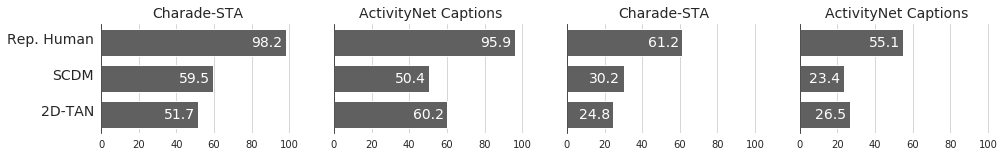

In [43]:
import seaborn as sns

def display_score_h(bar, ax):
    ax.text(
        bar.get_width()-10,
        bar.get_y()+bar.get_height()*.5,
        f"{bar.get_width():.1f}",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=14,
        color="w"
    )
    
sns.set_style("white")
f, axes = plt.subplots(1, 4, figsize=(16, 2), sharex=True, sharey=True)
pos = np.asarray([.2, .6])
height = 0.1
step = 0.1

done_put_label = False

for i, leaderboard in enumerate([charade_leaderboard_mr, activitynet_leaderboard_mr, charade_leaderboard_wmr, activitynet_leaderboard_wmr]):
    scores = leaderboard.values()
    pos = np.arange(len(scores)) * 0.4
    labels = leaderboard.keys()
    bars = axes[i].barh(pos, scores, height=0.3, color="#606060")
    for b in bars:
        display_score_h(b, axes[i])
    axes[i].xaxis.grid()

axes[0].set_title("Charade-STA", loc="center", fontsize=14)
axes[1].set_title("ActivityNet Captions", loc="center", fontsize=14)
axes[2].set_title("Charade-STA", loc="center", fontsize=14)
axes[3].set_title("ActivityNet Captions", loc="center", fontsize=14)

plt.yticks(pos+height*.5, labels)
plt.setp(axes[0].get_yticklabels(), fontsize = 14)

sns.despine(bottom=True)
# plt.savefig("reports/figures/multiref_metrics/mltiref_r_at_1.pdf", bbox_inches='tight')

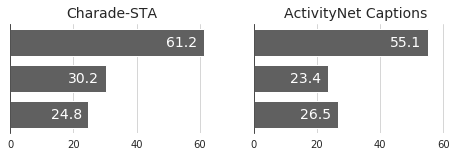

In [33]:
def display_score_h(bar, ax):
    ax.text(
        bar.get_width()-7,
        bar.get_y()+bar.get_height()*.5,
        f"{bar.get_width():.1f}",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=14,
        color="w"
    )
    
f, axes = plt.subplots(1, 2, figsize=(8, 2), sharex=True, sharey=True)
pos = np.asarray([.2, .6])
height = 0.1
step = 0.1

done_put_label = False

for i, leaderboard in enumerate([charade_leaderboard_wmr, activitynet_leaderboard_wmr]):
    scores = leaderboard.values()
    pos = np.arange(len(scores)) * 0.4
    labels = leaderboard.keys()
    bars = axes[i].barh(pos, scores, height=0.3, color="#606060")
    for b in bars:
        display_score_h(b, axes[i])

axes[0].set_title("Charade-STA", loc="center", fontsize=14)
axes[1].set_title("ActivityNet Captions", loc="center", fontsize=14)

axes[0].xaxis.grid()
axes[1].xaxis.grid()
plt.yticks([])

sns.despine(bottom=True)
plt.savefig("reports/figures/multiref_metrics/mltiref_weighted_r_at_1.pdf", bbox_inches='tight')

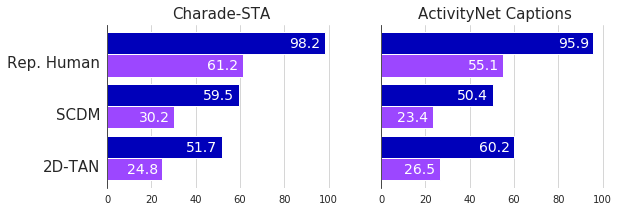

In [68]:
import seaborn as sns

def display_score_h(bar, ax):
    ax.text(
        bar.get_width()-9,
        bar.get_y()+bar.get_height()*.5,
        f"{bar.get_width():.1f}",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=14,
        color="w"
    )
    
sns.set_style("white")
f, axes = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
pos = np.asarray([.2, .6])
height = 0.1
step = 0.1

done_put_label = False

for i, leaderboard in enumerate([charade_leaderboard_mr, activitynet_leaderboard_mr, charade_leaderboard_wmr, activitynet_leaderboard_wmr]):
    scores = leaderboard.values()
    pos = np.arange(len(scores))*0.7 - 0.3 * (i > 1)
    labels = leaderboard.keys()
    color = "#9c47ff" if i>1 else "#0000ba"
    bars = axes[i%2].barh(pos, scores, height=0.3, color=color)
    for b in bars:
        display_score_h(b, axes[i%2])

axes[0].set_title("Charade-STA", loc="center", fontsize=15)
axes[1].set_title("ActivityNet Captions", loc="center", fontsize=15)
axes[0].xaxis.grid()
axes[1].xaxis.grid()

plt.yticks(pos+height*.5, labels)
plt.setp(axes[0].get_yticklabels(), fontsize = 15)

sns.despine(bottom=True)
plt.savefig("reports/figures/multiref_metrics/mltiref_r_at_1.pdf", bbox_inches='tight')